**Stock Price Prediction**

Predicting tomorrow's stock price based on:
- The stock's price fluctuations in the past 60 days
- The fluctuation in popular sentiment about the stock on Twitter.

# Setting the Environment

In [ ]:
! pip install --upgrade pandas
! pip install --upgrade pandas-datareader

In [ ]:
# Importing Libraries
import datetime as dt
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader as web
import re
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from textblob import TextBlob
import tweepy
from wordcloud import WordCloud

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
companyName = ["Amazon"]
companyTicker = "AMZN"

# Tomorrow's predicted stock price based on the stock's price fluctation in the past 60 days

## The training data

In [ ]:
# Fetch Data
trainingStartDate = dt.datetime(2022,6,1)
trainingEndDate = dt.datetime(2022,9,30)

training_stockprice_df = web.DataReader(companyTicker, "yahoo", trainingStartDate, trainingEndDate)
print (companyTicker + ":")
training_stockprice_df.head()

AMZN:


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-06-01,125.179001,120.622498,122.255997,121.683998,127528000.0,121.683998
2022-06-02,125.610001,120.044998,121.683998,125.511002,100560000.0,125.511002
2022-06-03,124.400002,121.046501,124.199997,122.349998,97604000.0,122.349998
2022-06-06,128.990005,123.809998,125.250000,124.790001,135269000.0,124.790001
2022-06-07,124.099998,120.629997,122.010002,123.000000,85156700.0,123.000000


In [ ]:
# scale the closing price
scaler = MinMaxScaler(feature_range=(0,1))
trainingScaledPrice = scaler.fit_transform (training_stockprice_df.Close.values.reshape(-1,1))

In [ ]:
# Create 60-day samples for each day
Y_train = []
X_train = []

timeWindow = 60
buffer = 0
for price in trainingScaledPrice[timeWindow:]:
  Y_train.append(price)
  X_train.append(trainingScaledPrice[buffer :timeWindow + buffer])
  buffer += 1

Y_train = np.array(Y_train)
X_train = np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

## Training Model

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))  
model.add(Dropout(0.2)) 
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
model.fit(X_train, Y_train, epochs=25, batch_size=int(len(Y_train) * 2/3))

In [ ]:
model.save("the_model")

## The testing data

In [ ]:
# Fetch Data
testingStartDate = trainingEndDate + dt.timedelta(1)
testingEndDate = dt.datetime.now()

testing_stockprice_df = web.DataReader(companyTicker, "yahoo", testingStartDate - dt.timedelta(90), testingEndDate)
print (companyTicker + ":")
testing_stockprice_df.head()

AMZN:


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-05,114.080002,106.320000,107.599998,113.500000,76583700,113.500000
2022-07-06,115.480003,112.010002,113.209999,114.330002,66958900,114.330002
2022-07-07,116.989998,113.489998,113.849998,116.330002,57872300,116.330002
2022-07-08,116.580002,113.690002,114.599998,115.540001,45719700,115.540001
2022-07-11,114.300003,110.870003,114.080002,111.750000,53487600,111.750000


In [ ]:
# scale the closing price
testingScaledPrice = scaler.transform (testing_stockprice_df.Close.values.reshape(-1,1))

In [ ]:
# Create 60-day samples for each day
Y_test = []
X_test = []

timeWindow = 60
buffer = 0
for price in testingScaledPrice[timeWindow:]:
  Y_test.append(price)
  X_test.append(testingScaledPrice[buffer :timeWindow + buffer])
  buffer += 1

Y_test = np.array(Y_test)
X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [ ]:
# Exclude rows that coincide with the training set
Y_test = Y_test[-sum(testing_stockprice_df.index >= testingStartDate):]
X_test = X_test[-sum(testing_stockprice_df.index >= testingStartDate):]

## Testing the model

In [ ]:
model = load_model('the_model')

In [ ]:
predicted_prices = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


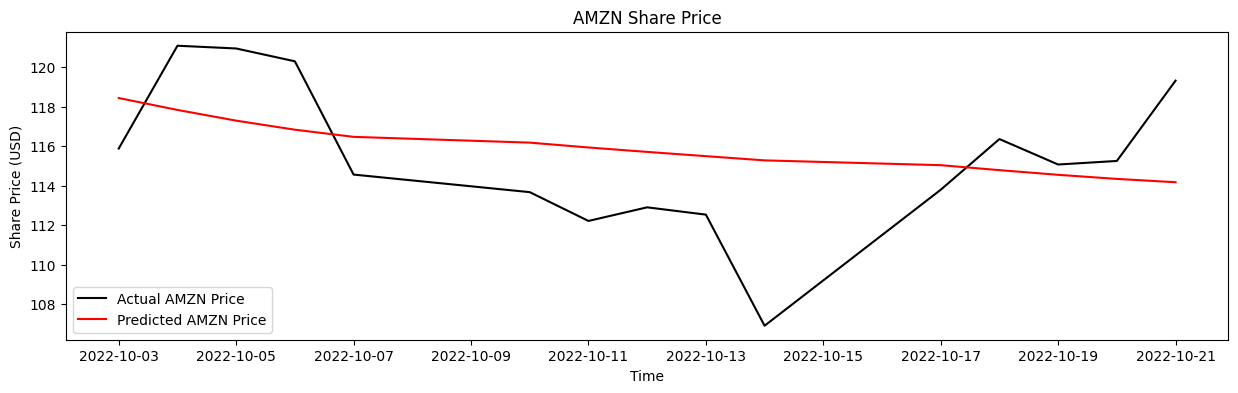

In [ ]:
# Plot prediction
x_axis = testing_stockprice_df[-sum(testing_stockprice_df.index >= testingStartDate):].index

plt.style.use('default')
plt.rcParams["figure.figsize"] = (len(x_axis), round(testing_stockprice_df.Close.values.ptp() / 10))
plt.plot(x_axis, testing_stockprice_df.Close.values[-sum(testing_stockprice_df.index >= testingStartDate):], color="black", label=f"Actual {companyTicker} Price")
plt.plot(x_axis, scaler.inverse_transform(predicted_prices), color="red", label=f"Predicted {companyTicker} Price")
plt.title(f"{companyTicker} Share Price")
plt.xlabel ("Time")
plt.ylabel ("Share Price (USD)")
plt.legend()
plt.show()

In [ ]:
# Prediction score
prediction_score = r2_score(Y_test, predicted_prices)
print("RMSE:", prediction_score)

RMSE: 0.10710159268513675


## Predicting tomorrow's stock price

In [ ]:
# Fetch Data
forecastStartDate = dt.datetime.now() - dt.timedelta(90)
forecastEndDate = dt.datetime.now()

forecastStockprice_df = web.DataReader(companyTicker, "yahoo", forecastStartDate, forecastEndDate)
print (companyTicker + ":")
forecastStockprice_df.head()

AMZN:


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-25,123.639999,120.029999,122.699997,121.139999,50221300,121.139999
2022-07-26,118.150002,114.529999,115.790001,114.809998,67075100,114.809998
2022-07-27,121.900002,117.160004,117.309998,120.970001,61582000,120.970001
2022-07-28,122.839996,118.080002,121.570000,122.279999,82245500,122.279999
2022-07-29,137.649994,132.410004,134.899994,134.949997,148892900,134.949997


In [ ]:
# scale the closing price
forecastScaledPrice = scaler.transform (forecastStockprice_df.Close.values.reshape(-1,1))

In [ ]:
X_forecast = forecastScaledPrice[-60:]
X_forecast = X_forecast.reshape((X_forecast.shape[1],X_forecast.shape[0],1))

In [ ]:
tomorrow_price = model.predict(X_forecast)
print(f"\nTomorrow's {companyTicker} Predicted Stock Price:")
print(f"{(dt.datetime.today() + dt.timedelta(1)).date()}: US${scaler.inverse_transform(tomorrow_price)[0][0]}")

1/1 [==============================] - 0s 24ms/step

Tomorrow's AMZN Predicted Stock Price:
2022-10-23: US$114.06324005126953


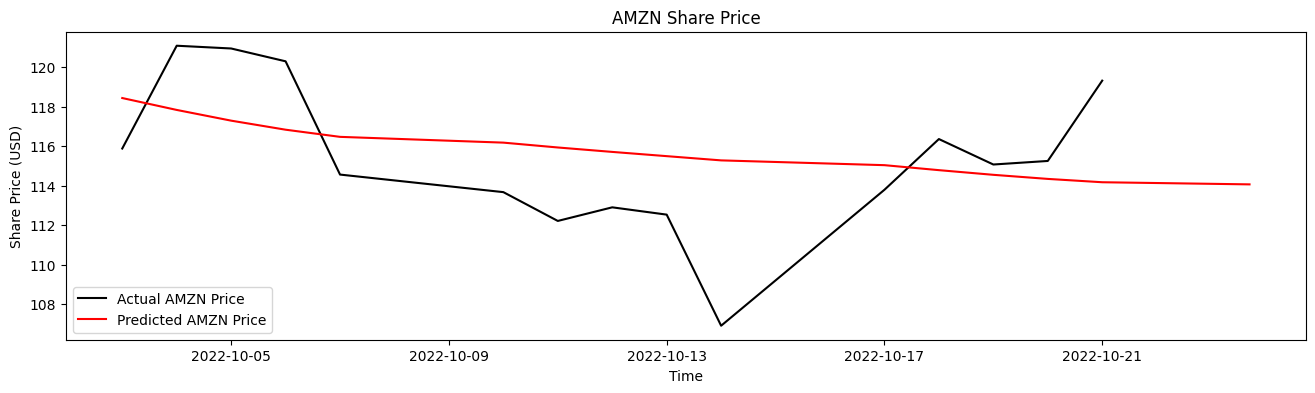

In [ ]:
# Plot forecast
x_axis = testing_stockprice_df[-sum(testing_stockprice_df.index >= testingStartDate):].reset_index().Date.append(pd.DataFrame([dt.datetime.today() + dt.timedelta(1)])[0])

plt.style.use('default')
plt.rcParams["figure.figsize"] = (len(x_axis), round(testing_stockprice_df.Close.values.ptp() / 10))
plt.plot(x_axis, np.append(testing_stockprice_df.Close.values[-sum(testing_stockprice_df.index >= testingStartDate):], np.nan), color="black", label=f"Actual {companyTicker} Price")
plt.plot(x_axis, np.append(scaler.inverse_transform(predicted_prices), np.array(scaler.inverse_transform(tomorrow_price)[0][0])), color="red", label=f"Predicted {companyTicker} Price")
plt.title(f"{companyTicker} Share Price")
plt.xlabel ("Time")
plt.ylabel ("Share Price (USD)")
plt.legend()
plt.show()

# Twitter Sentiment Analysis about the stock

## The Twitter App

In [ ]:
file = files.upload()
file_df = pd.read_csv("tt.csv")

Saving tt.csv to tt (1).csv


In [ ]:
# Twitter API Credentials
apiKey = file_df.Value[0]
apiSecret = file_df.Value[1]
accessToken = file_df.Value[3]
accessSecret = file_df.Value[4]

In [ ]:
# Authentication
authentication = tweepy.OAuthHandler(apiKey, apiSecret)
authentication.set_access_token(accessToken,accessSecret)

In [ ]:
# The API object
app = tweepy.API(authentication, wait_on_rate_limit=True)

## Fetch Twitter Data

In [ ]:
# Fetch top100 english and popular tweets for the company
tweet_df = pd.DataFrame (columns=["Company","Tweet"])

for company in companyName:
  top100Tweets = app.search(company, lang="en", result_type="popular", count="100")
  for tweet in top100Tweets:
    tweet_df = tweet_df.append({"Company":company,"Tweet":tweet.text}, ignore_index=True)

tweet_df

,Company,Tweet
0,Amazon,Giveaway! A $200 Amazon gift card to one perso...
1,Amazon,NEW: Amazon workers at 6 facilities in 3 state...
2,Amazon,🌠🌠GIVEAWAY TIME!! 🌠🌠\n\nRT + Like this post fo...
3,Amazon,AOC mocks her hecklers - no surprise. She stop...
4,Amazon,Shocking! How can @amazon so openly support su...
5,Amazon,#ContestAlert\n\nBe smart and win big!\nGuess ...
6,Amazon,"Participate by commenting your answer below, t..."
7,Amazon,Why is Amazon banning books from prominent aut...
8,Amazon,#ContestAlert \nOnly the sharpest eyes can spo...
9,Amazon,The Wallace Collection is the backdrop of My P...


## Clean the tweets

In [ ]:
def cleanTxt(txt):
  text = re.sub(r"@[A-Za-z0-9]+|https?://\S+|RT\s+|:|[^\x00-\x7F]+", "", txt)    # Remove mentions | Hyperlinks | Retweet flags | colons | emoticons
  text = re.sub("([a-z])([A-Z])", r"\1 \2", text)           # Space out mention strings  
  text = re.sub("#", ". ", text)                       # Remove mention hashes
  return text

In [ ]:
tweet_df.Tweet = tweet_df.Tweet.apply(cleanTxt)
tweet_df.head()

,Company,Tweet
0,Amazon,Giveaway! A $200 Amazon gift card to one perso...
1,Amazon,NEW Amazon workers at 6 facilities in 3 states...
2,Amazon,GIVEAWAY TIME!! \n\n+ Like this post for a cha...
3,Amazon,AOC mocks her hecklers - no surprise. She stop...
4,Amazon,Shocking! How can so openly support such ille...


## Tweet Analysis

In [ ]:
# Getting the tweet subjectivity and polarity
def getSubjectivity(txt):
  return TextBlob(txt).sentiment.subjectivity

def getPolarity(txt):
  return TextBlob(txt).sentiment.polarity

In [ ]:
tweet_df["Subjectivity"] = tweet_df.Tweet.apply(getSubjectivity)
tweet_df["Polarity"] = tweet_df.Tweet.apply(getPolarity)

tweet_df.head()

,Company,Tweet,Subjectivity,Polarity
0,Amazon,Giveaway! A $200 Amazon gift card to one perso...,0.000000,0.000000
1,Amazon,NEW Amazon workers at 6 facilities in 3 states...,0.310606,-0.015152
2,Amazon,GIVEAWAY TIME!! \n\n+ Like this post for a cha...,0.250000,0.500000
3,Amazon,AOC mocks her hecklers - no surprise. She stop...,0.454545,0.136364
4,Amazon,Shocking! How can so openly support such ille...,0.625000,-0.406250


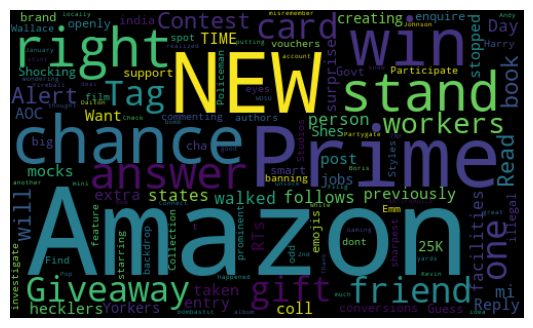

In [ ]:
# The Word Cloud
wordString = "".join([tweet for tweet in tweet_df.Tweet])
wordCloud = WordCloud(width = 500, height = 300, random_state=21, max_font_size=120).generate(wordString)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Tweet positivity
def getPositivity(polarity):
  if polarity < -0.2:
    return "Negative"
  elif polarity > 0.2:
    return "Positive"
  else:
    return "Neutral"

In [ ]:
tweet_df["Positivity"] = tweet_df.Polarity.apply(getPositivity)
tweet_df

,Company,Tweet,Subjectivity,Polarity,Positivity
0,Amazon,Giveaway! A $200 Amazon gift card to one perso...,0.000000,0.000000,Neutral
1,Amazon,NEW Amazon workers at 6 facilities in 3 states...,0.310606,-0.015152,Neutral
2,Amazon,GIVEAWAY TIME!! \n\n+ Like this post for a cha...,0.250000,0.500000,Positive
3,Amazon,AOC mocks her hecklers - no surprise. She stop...,0.454545,0.136364,Neutral
4,Amazon,Shocking! How can so openly support such ille...,0.625000,-0.406250,Negative
5,Amazon,. Contest Alert\n\nBe smart and win big!\nGues...,0.442857,0.317143,Positive
6,Amazon,"Participate by commenting your answer below, t...",0.400000,1.000000,Positive
7,Amazon,Why is Amazon banning books from prominent aut...,1.000000,0.500000,Positive
8,Amazon,. Contest Alert \nOnly the sharpest eyes can s...,0.595238,0.039683,Neutral
9,Amazon,The Wallace Collection is the backdrop of My P...,0.454545,0.136364,Neutral


In [ ]:
# Most positive
tweet_df.sort_values(by="Polarity", ascending=False).head()

,Company,Tweet,Subjectivity,Polarity,Positivity
6,Amazon,"Participate by commenting your answer below, t...",0.400,1.0,Positive
10,Amazon,For those wondering if another stint at No. 10...,0.600,0.7,Positive
2,Amazon,GIVEAWAY TIME!! \n\n+ Like this post for a cha...,0.250,0.5,Positive
7,Amazon,Why is Amazon banning books from prominent aut...,1.000,0.5,Positive
12,Amazon,I thought I knew a great deal about what happe...,0.475,0.5,Positive


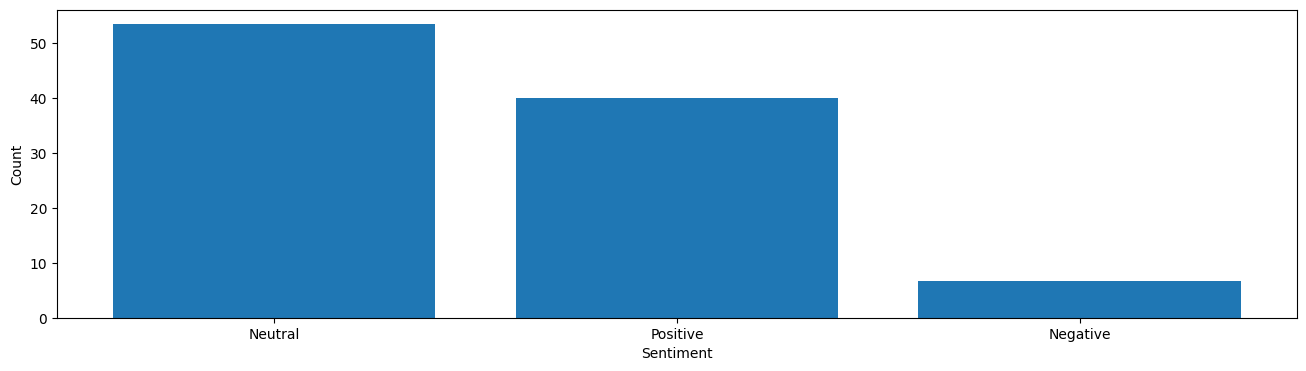

In [ ]:
# Plot sentiments
tweet_df.Positivity.value_counts()

plt.figure()
plt.bar(tweet_df.Positivity.value_counts().index, np.array(tweet_df.Positivity.value_counts().values)/ len(tweet_df) * 100)
plt.xlabel ("Sentiment")
plt.ylabel ("Count")
plt.show()

In [ ]:
# Percentage positive/negative
positiveTweets = int(sum(tweet_df.Positivity == "Positive") / len(tweet_df) * 100)
neutralTweets = int(sum(tweet_df.Positivity == "Neutral") / len(tweet_df) * 100)
negativeTweets = int(sum(tweet_df.Positivity == "Negative") / len(tweet_df) * 100)

In [ ]:
sentiment = {
    "Company":companyName[0],
    "Positivity":positiveTweets,
    "Negativity":negativeTweets
    }

sentiment_df = pd.DataFrame(sentiment,index=[dt.date.today()])
sentiment_df

,Company,Positivity,Negativity
2022-10-22,Amazon,40,6


# Twitter Sentiment impact on tomorrow's Predicted Stock Price

In [ ]:
# ToBeContinued